# Laboratorio 5 - Topic Modeling

Si richiede un'implementazione di un esercizio di Topic Modeling, utilizzando librerie open (come ad es. [GenSim](https://radimrehurek.com/gensim/)).
Si richiede l'utilizzo di un corpus di almeno 1k documenti.
Testare un algoritmo (ad esempio LDA) con più valori di k (num. di topics) e valutare la coerenza dei risultati, attraverso fine-tuning su parametri e pre-processing.

Update: essendo che spesso i topic, per essere interpretabili, devono contenere content words, potete pensare di filtrare solamente i sostantivi in fase di preprocessing (cioè POS=noun).

## Import delle librerie

In [20]:
!pip install pyLDAvis
!pip install datasets
!python3 -m spacy download en_core_web_sm
!pip install bertopic
import pandas as pd
from wordcloud import WordCloud
from gensim.models import CoherenceModel, LdaModel
import gensim.corpora as corpora
from datasets import load_dataset
import spacy
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
from bertopic import BERTopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 43.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Caricamento del dataset

Per lo svolgimento dell'esercizio viene utilizzato un dataset scaricato da *HuggingFace*. Esso è pensato originariamente per la classificazione, per cui possiamo considerare la classe target come il topic del testo.

Questo dataset possiede non solo la classe principale ma anche sottoclassi affini, che per le finalità di questa esercitazione possiamo non prendere in esame.

In [34]:
dataset = pd.DataFrame(load_dataset('DeveloperOats/DBPedia_Classes', split='validation')).sample(n=2000, random_state=99)
dataset['topic'] = dataset['l1']
dataset = dataset.drop(labels=['l1', 'l2', 'l3'], axis=1)
dataset = dataset[['topic', 'text']]
labels = list(set(dataset['topic']))
display(dataset)
print(labels)

Found cached dataset csv (/Users/mario/.cache/huggingface/datasets/DeveloperOats___csv/DeveloperOats--DBPedia_Classes-745bb82299e080ae/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


,topic,text
23462,Place,S. Darius and S. Girėnas Airport (S. Dariaus i...
22580,Agent,"Andrew Jacobs Jr. (February 24, 1932 – Decembe..."
12459,Event,The 1981 NCAA Division I Field Hockey Champion...
10287,Agent,Eddie Large (born 25 June 1941) is the stage n...
8492,Species,The Bailey's treefrog (Dendropsophus werneri) ...
...,...,...
9264,Work,"Doggone Cats (reissued as Dog Gone Cats), is a..."
32716,Agent,"Paul Calvin Carpenter (August 12, 1894 at Gran..."
33569,Place,Church of St Mary is a Grade I listed church i...
22596,Place,Farm Island Lake is a lake in the U.S. state o...


['TopicalConcept', 'SportsSeason', 'Event', 'UnitOfWork', 'Place', 'Agent', 'Device', 'Species', 'Work']


## Pre-processing dei dati

I testi scaricati sono processati per conservare solo il lemma delle parole *content*, ovvero i NOUN.

In [35]:
nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    tokens = set()
    for token in nlp(text.replace('\\n', ' ')):
        if token.pos_ == 'NOUN' and len(token.lemma_) > 2:
            tokens.add(token)
    return tokens

In [36]:
dataset['text'] = dataset['text'].map(lambda x: preprocess(x))
display(dataset)

,topic,text
23462,Place,"{aviation, 1980s, tourism, seat, city, airport..."
22580,Agent,"{personality, congressman, legislator, term, s..."
12459,Event,"{field, tournament, hockey, champion, champion..."
10287,Agent,"{stage, comedian, act, part, name}"
8492,Species,"{treefrog, land, werneri, frog, freshwater, sw..."
...,...,...
9264,Work,"{debut, cartoon, appearance, Doggone, brother,..."
32716,Agent,"{league, uncle, baseball, player, baseball, se..."
33569,Place,"{tower, brick, ministry, identification, build..."
22596,Place,"{state, farming, lake, rice, launches, name, n..."


## Ristrutturazione dei dati

Per praticità si riorganizzano i dati tramite un dizionario, che raccoglie per ogni etichetta (topic) l'insieme dei testi associati.

In [37]:
tokens_per_topic = {x: [] for x in labels}
for row in dataset.iterrows():
    join_list = tokens_per_topic[row[1][0]]
    join_list.extend(list(row[1][1]))
    tokens_per_topic[row[1][0]] = join_list

Successivamente si calcolano le frequenze relative alle parole per ogni topic.

In [38]:
topics_freqs = {x: '' for x in labels}
for k, v in tokens_per_topic.items():
    topics_freqs[k] = {}
    for w in v:
        topics_freqs[k][w.lemma_] = v.count(w)

## Plotting

Di seguito si visualizzano tramite CloudWord i termini più frequenti per ogni topic. Le CloudWord presentate sono ricavate con le etichette del dataset, e sono da considerarsi uno standard con cui confrontare i metodi successivi.

/Users/mario/Desktop/studio/TLN/dicaro/notebook/venv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


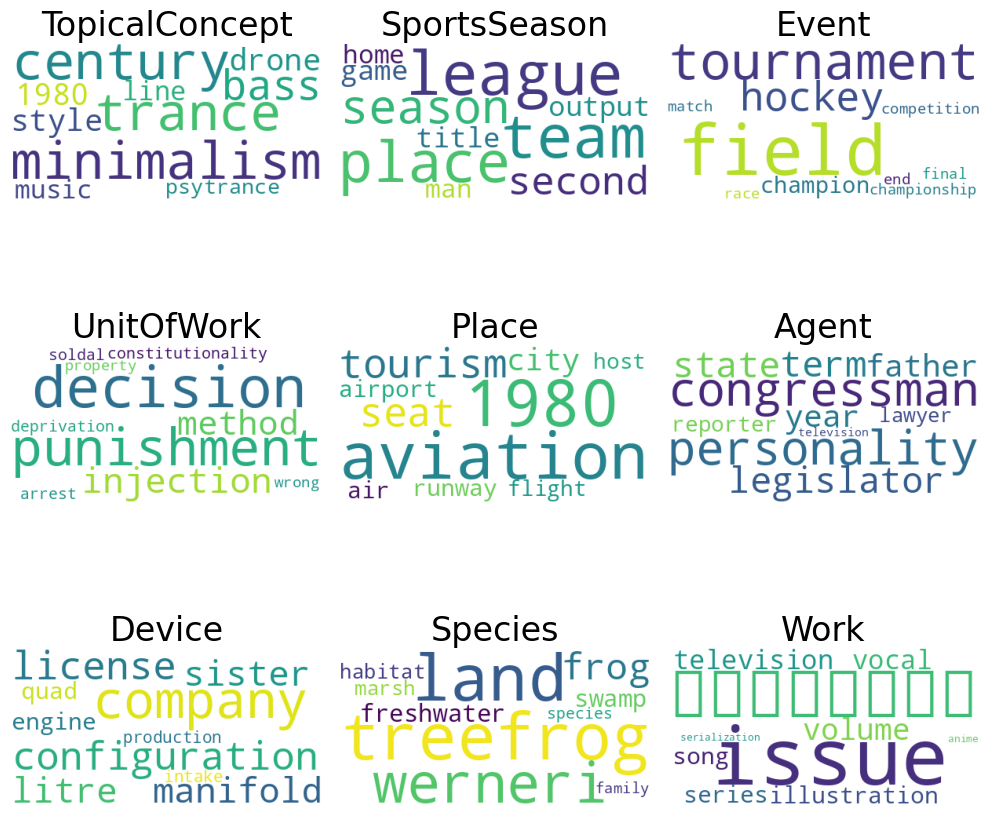

In [39]:
cloud = WordCloud(background_color='white', max_words=10, prefer_horizontal=True)
fig, axes = plt.subplots(3, 3, figsize=(10,10))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(topics_freqs[labels[i]])
    plt.gca().axis('off')
    plt.gca().imshow(cloud)
    plt.gca().set_title(labels[i], font=dict(size=24))

plt.tight_layout()
plt.show()

## Topic modelling con LDA

Un modo per ricavare i topic dalla sequenza di testi è tramite LDA (Latent Dirichlet Allocation).

In [40]:
texts_token = []
for l in dataset['text']:
    tmp = []
    for w in l:
        tmp.append(w.lemma_)
    texts_token.append(tmp)

In [41]:
dictionary = corpora.Dictionary(texts_token)
corpus = [dictionary.doc2bow(text) for text in texts_token]

Il numero di topic è ricavato automaticamente. Per fare ciò, si testano diversi valori possibili e si sceglie quello che restituisce risultati più coerenti tramite la valutazione del *CoherenceModel*.

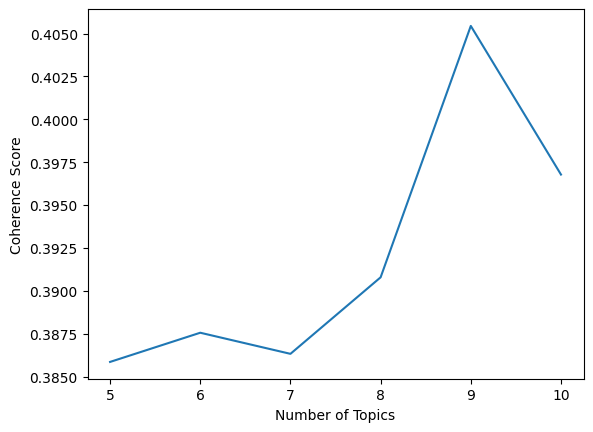

Numero di topic con maggiore coerenza: 9


In [49]:
topics = []
score = []
for i in range(5,11,1):
   lda_model_eval = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, random_state=42)
   cm = CoherenceModel(model=lda_model_eval, dictionary=dictionary, texts=texts_token)
   topics.append(i)
   score.append(cm.get_coherence())
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

candidate_topic_num = score.index(sorted(score, reverse=True)[0]) + 5
print('Numero di topic con maggiore coerenza:', candidate_topic_num)

Una volta ricavato il numero di topic, si effettua il plotting dividendo i testi e le parole chiave tramite il modello LDA.

Si può notare che alcune parole chiave sono le stesse delle CloudWord di riferimento, dimostrando quindi di aver ottenuto una divisione ragionevole per i testi in input.

/Users/mario/Desktop/studio/TLN/dicaro/notebook/venv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


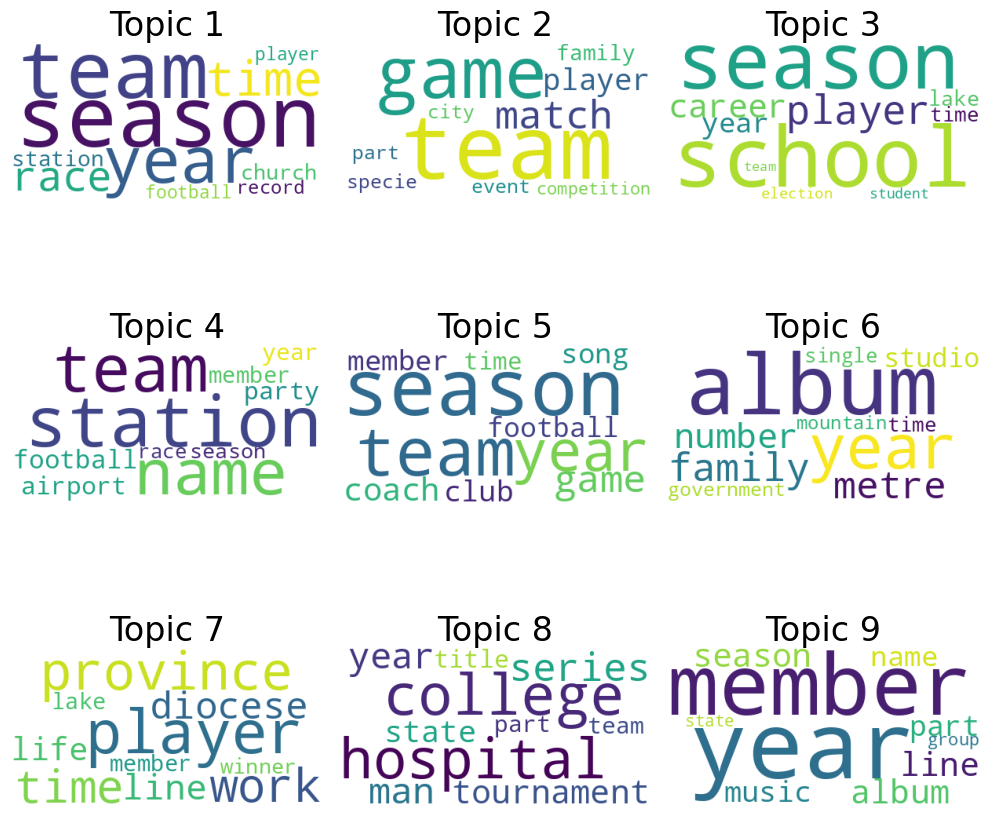

In [50]:
lda_model = LdaModel(corpus=corpus, num_topics=candidate_topic_num, id2word=dictionary, random_state=42)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

topics = lda_model.show_topics(formatted=False, num_topics=candidate_topic_num, num_words=10)
fig, axes = plt.subplots(3, 3, figsize=(10,10))

cloud = WordCloud(background_color='white', max_words=10, prefer_horizontal=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words)
    plt.gca().axis('off')
    plt.gca().imshow(cloud)
    plt.gca().set_title(f'Topic {i+1}', font=dict(size=24))

plt.tight_layout()
plt.show()